In [ ]:
!pip install roboflow
!pip install torchmetrics
!pip install torch torchvision torchaudio
!pip install pytorch-lightning
!pip install segmentation-models-pytorch
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install python-docx
!pip install -U albumentations

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("").project("")
version = project.version()
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00


Extracting Dataset Version Zip to fetal-brain-segmentation-7 in coco:: 100%|██████████| 63/63 [00:00<00:00, 3639.08it/s]


In [2]:
#Procesamiento de anotaciones COCO y generación de máscaras segmentadas coloreadas.
import os
import json
import shutil
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np

class CocoMaskProcessor:
    def __init__(self, input_dir: str, output_dir: str, coco_json: str):
        """
        Inicializador del procesador con las rutas de entrada y salida, y el archivo JSON COCO.
        """
        self.input_dir = Path(input_dir) #Carpeta con imágenes originales.
        self.output_dir = Path(output_dir) #Carpeta donde se guardan imágenes y máscaras.
        self.coco_json = Path(coco_json) #Archivo JSON con las anotaciones COCO
        self.images_dir = self.output_dir / "images" #Subcarpeta para imágenes
        self.masks_dir = self.output_dir / "image_masks" #Subcarpeta para máscaras.
        self._prepare_directories() #Crear carpetas si no existen
        self.annotations = self._load_annotations() #Cargar anotaciones COCO
        self.allowed_categories = ["cerebelo", "cisterna-magna", "vermis-cerebeloso"] #Categorías a usar
        self.filtered_categories = self._filter_categories() #Filtrar categorias permitidas
        self.category_colors = self._generate_category_colors() #asignar color para cada categoría

    def _prepare_directories(self):
        """
        Crea las carpetas de salida para imágenes y máscaras si no existen.
        """
        self.images_dir.mkdir(parents=True, exist_ok=True)
        self.masks_dir.mkdir(parents=True, exist_ok=True)

    def _load_annotations(self):
        """
        Lectura del archivo JSON COCO y devolució del contenido como diccionario.
        """
        with open(self.coco_json, "r") as f:
            return json.load(f)

    def _filter_categories(self):
        """
        Filtración y devuelvolución de solo las categorías permitidas del JSON COCO.
        Devuelve un diccionario {id_categoria: nombre_categoria}.
        """
        return {
            cat["id"]: cat["name"]
            for cat in self.annotations["categories"]
            if cat["name"] in self.allowed_categories
        }

    def _generate_category_colors(self):
        """
        Generación de un color RGB único para cada categoría.
        Devuelve un diccionario {id_categoria: color}.
        """
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Una para cada clase
        return {
            cat_id: colors[i]
            for i, (cat_id, name) in enumerate(self.filtered_categories.items())
        }

    def process(self):
        """
        Procesamiento de las imágenes y máscaras segmentadas.
        """
        for image_info in self.annotations.get("images", []):
            image_name = image_info["file_name"]
            image_path = self.input_dir / image_name
            if image_path.exists():
                self._copy_image(image_path)
                self._create_mask(image_info, image_path)

    def _copy_image(self, image_path: Path):
        """
        Copia la imagen original a la carpeta de salida.
        """
        shutil.copy(image_path, self.images_dir / image_path.name)

    def _create_mask(self, image_info, image_path: Path):
        """
        Crea una máscara segmentada coloreada a partir de las anotaciones COCO.
        """
        with Image.open(image_path) as img:
            width, height = img.size

        mask = Image.new("RGB", (width, height), (0, 0, 0))
        draw = ImageDraw.Draw(mask)

        for annotation in self.annotations.get("annotations", []):
            if annotation["image_id"] == image_info["id"]:
                category_id = annotation["category_id"]
                if category_id in self.filtered_categories:
                    color = self.category_colors[category_id]
                    # Cada segmentación es una lista de puntos del poligono
                    for seg in annotation["segmentation"]:
                        points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
                        draw.polygon(points, outline=color, fill=color)

        # Asignación de un valor entero (clase) a cada píxel según el color.
        mask_np = np.array(mask)
        mask_class = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)
        for idx, (class_id, color) in enumerate(self.category_colors.items(), start=1):
            mask_class[np.all(mask_np == np.array(color), axis=-1)] = idx

        mask_img = Image.fromarray(mask_class)
        mask_img.save(self.masks_dir / image_info["file_name"])





# Crear y ejecutar el procesador
processor = CocoMaskProcessor("/content/fetal-brain-segmentation-7/train", "results", "/content/fetal-brain-segmentation-7/train/_annotations.coco.json")
processor.process()


In [ ]:
import os
import cv2
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# Directorios
data_dir = "results"
x_images_dir = os.path.join(data_dir, "images")
y_masks_dir = os.path.join(data_dir, "image_masks")


def split_dataset(images_dir, masks_dir, train_size=26, valid_size=4, test_size=4):
    """ División del dataset en conjuntos de entrenamiento, validación y prueba. """
    all_ids = os.listdir(images_dir)
    train_ids, temp_ids = train_test_split(all_ids, test_size=(valid_size + test_size), random_state=42)
    valid_ids, test_ids = train_test_split(temp_ids, test_size=test_size, random_state=42)
    return train_ids, valid_ids, test_ids

train_ids, valid_ids, test_ids = split_dataset(x_images_dir, y_masks_dir)

class Dataset:
    """ Dataset personalizado para cargar imágenes y máscaras. """
    CLASSES = ["unlabelled", "cerebelo", "cisterna-magna", "vermis-cerebeloso"]

    def __init__(self, images_dir, masks_dir, ids, transform=None):
        """ Inicializador del dataser."""
        self.ids = ids
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.transform = transform
        self.class_map = {i: i for i in range(len(self.CLASSES))}

    def __getitem__(self, i):
        """ Cargar imagen y máscara. """

        # Carga la imagen RGB.
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Imagen no encontrada: {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #Carga la máscara en escala de grises.
        mask = cv2.imread(self.masks_fps[i], 0)
        if mask is None:
            raise FileNotFoundError(f"Máscara no encontrada: {self.masks_fps[i]}")

        #Reasigna los valores de máscara según el mapeo de clases.
        mask_remap = np.zeros_like(mask)
        for class_value, new_value in self.class_map.items():
            mask_remap[mask == class_value] = new_value

        #Aplica las transformaciones
        if self.transform:
            augmented = self.transform(image=image, mask=mask_remap)
            image = augmented["image"]
            mask_remap = augmented["mask"].long()  # Asegura que es LongTensor
        else:
            #Sino, convierte la imagen y máscara a tensores
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
            mask_remap = torch.tensor(mask_remap, dtype=torch.long)

        return image, mask_remap

    def __len__(self):
        return len(self.ids)

# Collate
def collate_fn(batch):
    """ Agrupación de lotes, eliminando elementos None. """
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return None
    images, masks = zip(*batch)
    return torch.stack(images), torch.stack(masks)

#Data Augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(),
    ToTensorV2()
])

#Normalización para validación y test.
valid_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

# Datasets y dataloaders
train_dataset = Dataset(x_images_dir, y_masks_dir, train_ids, transform=train_transform)
valid_dataset = Dataset(x_images_dir, y_masks_dir, valid_ids, transform=valid_transform)
test_dataset = Dataset(x_images_dir, y_masks_dir, test_ids, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

class CerebelumModelSegmentation(pl.LightningModule):
    """ Definición del módulo Lightning para el modelo de segmentación. """
    def __init__(self, arch, encoder_name, in_channels, out_classes):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes
        )
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        self.loss_fn = smp.losses.DiceLoss(mode="multiclass", from_logits=True)

    def forward(self, image):
        """ Normalizar la imagen y pasarla por el modelo"""
        image = (image - self.mean) / self.std
        return self.model(image)

    def training_step(self, batch, batch_idx):
        image, mask = batch
        logits_mask = self(image)
        loss = self.loss_fn(logits_mask, mask)
        # Registrar la perdida para monitorizar durante el entrenamiento.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, mask = batch
        logits_mask = self(image)
        loss = self.loss_fn(logits_mask, mask)
         # Registrar la perdida de validación para monitorización.
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        image, mask = batch
        logits_mask = self(image)
        loss = self.loss_fn(logits_mask, mask)
        # Registrar la perdida de test para evaluación final.
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# Callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", patience=30, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(
    dirpath="./checkpoints",
    filename="cerebelum_model-{epoch}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    verbose=True
)

# Entrenamiento
EPOCHS = 200
OUT_CLASSES = len(train_dataset.CLASSES)

model = CerebelumModelSegmentation("linknet", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    log_every_n_steps=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)

trainer.test(model, dataloaders=test_loader)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)


# Guardar pesos del mejor modelo entrenado
best_model_path = checkpoint_callback.best_model_path
checkpoint = torch.load(best_model_path)
torch.save(model.state_dict(), "cerebelum_model_weights.pth")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.9078391790390015     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Linknet  | 30.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
30.6 M    Trainable params
0         Non-trainable params
30.6 M    Total params
122.599   Total estimated model params size (MB)
228       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.892
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 24: 'val_loss' reached 0.89209 (best 0.89209), saving model to '/content/checkpoints/cerebelum_model-epoch=0-val_loss=0.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.874
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 48: 'val_loss' reached 0.87355 (best 0.87355), saving model to '/content/checkpoints/cerebelum_model-epoch=1-val_loss=0.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.856
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 72: 'val_loss' reached 0.85558 (best 0.85558), saving model to '/content/checkpoints/cerebelum_model-epoch=2-val_loss=0.86.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.837
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 96: 'val_loss' reached 0.83739 (best 0.83739), saving model to '/content/checkpoints/cerebelum_model-epoch=3-val_loss=0.84.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.828
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 120: 'val_loss' reached 0.82807 (best 0.82807), saving model to '/content/checkpoints/cerebelum_model-epoch=4-val_loss=0.83.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.822
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 144: 'val_loss' reached 0.82223 (best 0.82223), saving model to '/content/checkpoints/cerebelum_model-epoch=5-val_loss=0.82.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.819
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 168: 'val_loss' reached 0.81850 (best 0.81850), saving model to '/content/checkpoints/cerebelum_model-epoch=6-val_loss=0.82.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 192: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.785
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 216: 'val_loss' reached 0.78506 (best 0.78506), saving model to '/content/checkpoints/cerebelum_model-epoch=8-val_loss=0.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.764
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 240: 'val_loss' reached 0.76351 (best 0.76351), saving model to '/content/checkpoints/cerebelum_model-epoch=9-val_loss=0.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.740
INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 264: 'val_loss' reached 0.74008 (best 0.74008), saving model to '/content/checkpoints/cerebelum_model-epoch=10-val_loss=0.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.733
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 288: 'val_loss' reached 0.73309 (best 0.73309), saving model to '/content/checkpoints/cerebelum_model-epoch=11-val_loss=0.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.713
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 312: 'val_loss' reached 0.71345 (best 0.71345), saving model to '/content/checkpoints/cerebelum_model-epoch=12-val_loss=0.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.697
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 336: 'val_loss' reached 0.69665 (best 0.69665), saving model to '/content/checkpoints/cerebelum_model-epoch=13-val_loss=0.70.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.692
INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 360: 'val_loss' reached 0.69161 (best 0.69161), saving model to '/content/checkpoints/cerebelum_model-epoch=14-val_loss=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.683
INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 384: 'val_loss' reached 0.68312 (best 0.68312), saving model to '/content/checkpoints/cerebelum_model-epoch=15-val_loss=0.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.657
INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 408: 'val_loss' reached 0.65674 (best 0.65674), saving model to '/content/checkpoints/cerebelum_model-epoch=16-val_loss=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.633
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 432: 'val_loss' reached 0.63289 (best 0.63289), saving model to '/content/checkpoints/cerebelum_model-epoch=17-val_loss=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 456: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 480: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 504: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.597
INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 528: 'val_loss' reached 0.59721 (best 0.59721), saving model to '/content/checkpoints/cerebelum_model-epoch=21-val_loss=0.60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.585
INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 552: 'val_loss' reached 0.58549 (best 0.58549), saving model to '/content/checkpoints/cerebelum_model-epoch=22-val_loss=0.59.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.574
INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 576: 'val_loss' reached 0.57425 (best 0.57425), saving model to '/content/checkpoints/cerebelum_model-epoch=23-val_loss=0.57.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.565
INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 600: 'val_loss' reached 0.56485 (best 0.56485), saving model to '/content/checkpoints/cerebelum_model-epoch=24-val_loss=0.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.563
INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 624: 'val_loss' reached 0.56334 (best 0.56334), saving model to '/content/checkpoints/cerebelum_model-epoch=25-val_loss=0.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.546
INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 648: 'val_loss' reached 0.54570 (best 0.54570), saving model to '/content/checkpoints/cerebelum_model-epoch=26-val_loss=0.55.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.539
INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 672: 'val_loss' reached 0.53898 (best 0.53898), saving model to '/content/checkpoints/cerebelum_model-epoch=27-val_loss=0.54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 696: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.534
INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 720: 'val_loss' reached 0.53390 (best 0.53390), saving model to '/content/checkpoints/cerebelum_model-epoch=29-val_loss=0.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.520
INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 744: 'val_loss' reached 0.51969 (best 0.51969), saving model to '/content/checkpoints/cerebelum_model-epoch=30-val_loss=0.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.511
INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 768: 'val_loss' reached 0.51112 (best 0.51112), saving model to '/content/checkpoints/cerebelum_model-epoch=31-val_loss=0.51.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 792: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 816: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 840: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 864: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.508
INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 888: 'val_loss' reached 0.50834 (best 0.50834), saving model to '/content/checkpoints/cerebelum_model-epoch=36-val_loss=0.51.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.504
INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 912: 'val_loss' reached 0.50438 (best 0.50438), saving model to '/content/checkpoints/cerebelum_model-epoch=37-val_loss=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 936: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 960: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.503
INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 984: 'val_loss' reached 0.50336 (best 0.50336), saving model to '/content/checkpoints/cerebelum_model-epoch=40-val_loss=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.499
INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 1008: 'val_loss' reached 0.49876 (best 0.49876), saving model to '/content/checkpoints/cerebelum_model-epoch=41-val_loss=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 1032: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 1056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 1080: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.496
INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 1104: 'val_loss' reached 0.49638 (best 0.49638), saving model to '/content/checkpoints/cerebelum_model-epoch=45-val_loss=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.496
INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 1128: 'val_loss' reached 0.49563 (best 0.49563), saving model to '/content/checkpoints/cerebelum_model-epoch=46-val_loss=0.50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 1152: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 1176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 1224: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.492
INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 1248: 'val_loss' reached 0.49240 (best 0.49240), saving model to '/content/checkpoints/cerebelum_model-epoch=51-val_loss=0.49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 1272: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 1296: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.488
INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 1320: 'val_loss' reached 0.48778 (best 0.48778), saving model to '/content/checkpoints/cerebelum_model-epoch=54-val_loss=0.49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 1344: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 1368: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 1392: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 1416: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 1440: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 1464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 1488: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 1512: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.480
INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 1536: 'val_loss' reached 0.48000 (best 0.48000), saving model to '/content/checkpoints/cerebelum_model-epoch=63-val_loss=0.48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 1560: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.478
INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 1584: 'val_loss' reached 0.47827 (best 0.47827), saving model to '/content/checkpoints/cerebelum_model-epoch=65-val_loss=0.48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 1608: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.475
INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 1632: 'val_loss' reached 0.47501 (best 0.47501), saving model to '/content/checkpoints/cerebelum_model-epoch=67-val_loss=0.48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.463
INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 1656: 'val_loss' reached 0.46259 (best 0.46259), saving model to '/content/checkpoints/cerebelum_model-epoch=68-val_loss=0.46.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 1680: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 1704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 1728: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 1752: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 1776: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.461
INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 1800: 'val_loss' reached 0.46112 (best 0.46112), saving model to '/content/checkpoints/cerebelum_model-epoch=74-val_loss=0.46.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.458
INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 1824: 'val_loss' reached 0.45826 (best 0.45826), saving model to '/content/checkpoints/cerebelum_model-epoch=75-val_loss=0.46.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.454
INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 1848: 'val_loss' reached 0.45405 (best 0.45405), saving model to '/content/checkpoints/cerebelum_model-epoch=76-val_loss=0.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 1872: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.452
INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 1896: 'val_loss' reached 0.45206 (best 0.45206), saving model to '/content/checkpoints/cerebelum_model-epoch=78-val_loss=0.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.451
INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 1920: 'val_loss' reached 0.45051 (best 0.45051), saving model to '/content/checkpoints/cerebelum_model-epoch=79-val_loss=0.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.449
INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 1944: 'val_loss' reached 0.44852 (best 0.44852), saving model to '/content/checkpoints/cerebelum_model-epoch=80-val_loss=0.45.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 1968: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 1992: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 2016: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 2040: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 2064: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.430
INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 2088: 'val_loss' reached 0.43044 (best 0.43044), saving model to '/content/checkpoints/cerebelum_model-epoch=86-val_loss=0.43.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 2112: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 2136: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 2160: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 2184: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 2208: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.419
INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 2232: 'val_loss' reached 0.41877 (best 0.41877), saving model to '/content/checkpoints/cerebelum_model-epoch=92-val_loss=0.42.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 2256: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 2280: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 2304: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.415
INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 2328: 'val_loss' reached 0.41480 (best 0.41480), saving model to '/content/checkpoints/cerebelum_model-epoch=96-val_loss=0.41.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.408
INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 2352: 'val_loss' reached 0.40777 (best 0.40777), saving model to '/content/checkpoints/cerebelum_model-epoch=97-val_loss=0.41.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 2376: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 2400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 2424: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 2448: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 2472: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 2496: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 2520: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 2544: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 2568: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 2592: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.390
INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 2616: 'val_loss' reached 0.38976 (best 0.38976), saving model to '/content/checkpoints/cerebelum_model-epoch=108-val_loss=0.39.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 2640: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 2664: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 111, global step 2688: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 112, global step 2712: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 113, global step 2736: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 114, global step 2760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.367
INFO:pytorch_lightning.utilities.rank_zero:Epoch 115, global step 2784: 'val_loss' reached 0.36651 (best 0.36651), saving model to '/content/checkpoints/cerebelum_model-epoch=115-val_loss=0.37.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.341
INFO:pytorch_lightning.utilities.rank_zero:Epoch 116, global step 2808: 'val_loss' reached 0.34074 (best 0.34074), saving model to '/content/checkpoints/cerebelum_model-epoch=116-val_loss=0.34.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 117, global step 2832: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.328
INFO:pytorch_lightning.utilities.rank_zero:Epoch 118, global step 2856: 'val_loss' reached 0.32812 (best 0.32812), saving model to '/content/checkpoints/cerebelum_model-epoch=118-val_loss=0.33.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 119, global step 2880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.326
INFO:pytorch_lightning.utilities.rank_zero:Epoch 120, global step 2904: 'val_loss' reached 0.32628 (best 0.32628), saving model to '/content/checkpoints/cerebelum_model-epoch=120-val_loss=0.33.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.309
INFO:pytorch_lightning.utilities.rank_zero:Epoch 121, global step 2928: 'val_loss' reached 0.30874 (best 0.30874), saving model to '/content/checkpoints/cerebelum_model-epoch=121-val_loss=0.31.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.291
INFO:pytorch_lightning.utilities.rank_zero:Epoch 122, global step 2952: 'val_loss' reached 0.29104 (best 0.29104), saving model to '/content/checkpoints/cerebelum_model-epoch=122-val_loss=0.29.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 123, global step 2976: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 124, global step 3000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 125, global step 3024: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 126, global step 3048: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 127, global step 3072: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 128, global step 3096: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 129, global step 3120: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 130, global step 3144: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 131, global step 3168: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 132, global step 3192: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 133, global step 3216: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 134, global step 3240: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 135, global step 3264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 136, global step 3288: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 137, global step 3312: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 138, global step 3336: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 139, global step 3360: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 140, global step 3384: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 141, global step 3408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 142, global step 3432: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 143, global step 3456: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 144, global step 3480: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 145, global step 3504: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 146, global step 3528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 147, global step 3552: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 148, global step 3576: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 149, global step 3600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 150, global step 3624: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 151, global step 3648: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 30 records. Best score: 0.291. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 152, global step 3672: 'val_loss' was not in top 1


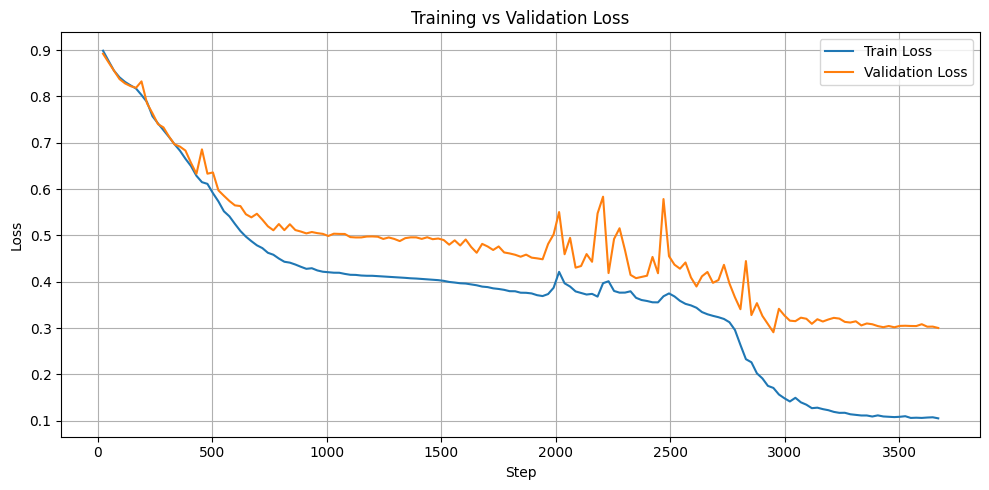

In [43]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Ruta del archivo de eventos de TensorBoard generado por PyTorch Lightning
# Cambiar cada vez que se ejecute el entrenamiento
log_dir = "/content/lightning_logs/version_9/events.out.tfevents.1748459624.4d57f2ee9243.282.19"

# Carga del archivo de eventos
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

#Inicialización de variables.
train_loss_tag = None
val_loss_tag = None

#Estración de las etiquetas disponibles del log.
available_tags = ea.Tags()["scalars"]
# Busqueda automática de las etiquetas correspondientes a la pérdida de entrenamiento y validación
for tag in available_tags:
    if "train" in tag.lower() and "loss" in tag.lower():
        train_loss_tag = tag
    elif "val" in tag.lower() and "loss" in tag.lower():
        val_loss_tag = tag

if not train_loss_tag or not val_loss_tag:
    raise ValueError("Couldn't find tags for train/val loss. Found tags: " + str(available_tags))

# Extraemos los eventos (pérdidas por paso) correspondientes a cada conjunto
train_loss_events = ea.Scalars(train_loss_tag)
val_loss_events = ea.Scalars(val_loss_tag)

# Guardamos los pasos (epochs) y los valores de pérdida
train_steps = [e.step for e in train_loss_events]
train_loss = [e.value for e in train_loss_events]

val_steps = [e.step for e in val_loss_events]
val_loss = [e.value for e in val_loss_events]

# Visualizamos las curvas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(val_steps, val_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Guardar el gráfico
output_dir = "plots"  # Directory to save the plot
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
plot_path = os.path.join(output_dir, "training_vs_validation_loss.png")
plt.savefig(plot_path, dpi=300)  # Save plot with high resolution


# Mostrar el gráfico.
plt.show()

In [44]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap  # Para crear un colormap personalizado

# Directorios de salida para imágenes y tablas como imágenes
output_images_dir = "complete_results/images"
output_tables_dir = "complete_results/table_images"
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_tables_dir, exist_ok=True)

# Actualizar nombres de clases desde el Dataset (excluyendo "unlabelled")
class_names = {idx: name for idx, name in enumerate(["cerebelo", "cisterna-magna", "vermis-cerebeloso"], start=1)}

# Colormap personalizado (colores específicos para cada clase)
custom_colors = ["black", "blue", "green", "red"]  # Colores: 0=fondo, 1=cerebelo, 2=cisterna-magna, 3=vermis-cerebeloso
custom_colormap = ListedColormap(custom_colors)

def save_image(image, true_mask, prediction, image_idx):
    """
    Guarda la imagen original, la máscara real y la predicción como una sola imagen combinada.
    """
    # Convertir imagen para visualización
    image = image.permute(1, 2, 0).numpy()  # Cambiar de [C, H, W] a [H, W, C]
    image = (image - image.min()) / (image.max() - image.min())  # Normalizar valores a [0, 1]

    fig = plt.figure(figsize=(15, 6))  # Ajustar el tamaño de la figura
    plt.subplots_adjust(top=1)

    # Imagen original
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(image)
    ax1.set_title("Imagen Original", fontsize=16, pad=15)
    ax1.axis("off")

    # Máscara real con colormap personalizado
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(true_mask, cmap=custom_colormap, vmin=0, vmax=3)
    ax2.set_title("Máscara Real", fontsize=16, pad=15)
    ax2.axis("off")

    # Predicción con colormap personalizado
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(prediction, cmap=custom_colormap, vmin=0, vmax=3)
    ax3.set_title("Predicción", fontsize=16, pad=15)
    ax3.axis("off")

    # Guardar como imagen
    output_file = os.path.join(output_images_dir, f"image_{image_idx}.png")
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.close(fig)
    print(f"Imagen guardada en: {output_file}")

def save_table_as_image(table_data, image_idx):
    """
    Guarda la tabla con las métricas por clase como una imagen PNG y añade una fila de media.
    """
    table_data["Clase"] = table_data["Clase"].map(class_names)
    precision_mean = table_data["Precisión (%)"].mean()
    iou_mean = table_data["IoU (%)"].mean()
    media_row = pd.DataFrame({
        "Clase": ["Media"],
        "Total píxeles": [""],
        "Correctos": [""],
        "Precisión (%)": [round(precision_mean, 2)],
        "IoU (%)": [round(iou_mean, 2)]
    })
    table_data = pd.concat([table_data, media_row], ignore_index=True)

    fig, ax = plt.subplots(figsize=(8, len(table_data) * 0.5))
    ax.axis("off")
    table = ax.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        cellLoc="center",
        loc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(table_data.columns))))

    for key, cell in table.get_celld().items():
        cell.set_height(0.15)

    output_file = os.path.join(output_tables_dir, f"table_{image_idx}.png")
    plt.savefig(output_file, dpi=300)
    plt.close(fig)
    print(f"Tabla guardada como imagen en: {output_file}")

def calculate_and_save_results(model, dataset, num_classes):
    """
    Calcula métricas, genera predicciones y guarda imágenes y tablas por separado como imágenes PNG.
    """
    model.eval()

    for idx in range(len(dataset)):
        image, true_mask = dataset[idx]
        image = image.unsqueeze(0)
        true_mask = true_mask.numpy().astype(np.uint8)

        with torch.no_grad():
            prediction = model(image).softmax(dim=1).argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

        total_pixels_per_class = {cls: 0 for cls in range(1, num_classes + 1)}
        correct_pixels_per_class = {cls: 0 for cls in range(1, num_classes + 1)}
        accuracy_per_class = []
        iou_per_class = []

        # Calcular intersección y precisión por clase
        for cls in range(1, num_classes + 1):
            real_class_pixels = (true_mask == cls)
            pred_class_pixels = (prediction == cls)

            # Total y correctos
            total_pixels_per_class[cls] = real_class_pixels.sum()
            correct_pixels_per_class[cls] = np.sum(real_class_pixels & pred_class_pixels)

            # Precisión por clase
            accuracy = (correct_pixels_per_class[cls] / total_pixels_per_class[cls] * 100) if total_pixels_per_class[cls] > 0 else 0
            accuracy_per_class.append(round(accuracy, 2))

            # IoU por clase
            intersection = np.logical_and(real_class_pixels, pred_class_pixels).sum()
            union = np.logical_or(real_class_pixels, pred_class_pixels).sum()
            iou = (intersection / union * 100) if union > 0 else 0
            iou_per_class.append(round(iou, 2))

        # Crear la tabla con los resultados por clase
        table_data = pd.DataFrame({
            "Clase": [cls for cls in range(1, num_classes + 1)],
            "Total píxeles": [total_pixels_per_class[cls] for cls in range(1, num_classes + 1)],
            "Correctos": [correct_pixels_per_class[cls] for cls in range(1, num_classes + 1)],
            "Precisión (%)": accuracy_per_class,
            "IoU (%)": iou_per_class
        })

        save_image(image.squeeze(0), true_mask, prediction, idx + 1)
        save_table_as_image(table_data, idx + 1)

# Número de clases en el dataset
num_classes = 3

# Calcular y guardar imágenes y tablas como imágenes PNG
calculate_and_save_results(model, test_dataset, num_classes)


Imagen guardada en: complete_results/images/image_1.png
Tabla guardada como imagen en: complete_results/table_images/table_1.png
Imagen guardada en: complete_results/images/image_2.png
Tabla guardada como imagen en: complete_results/table_images/table_2.png
Imagen guardada en: complete_results/images/image_3.png
Tabla guardada como imagen en: complete_results/table_images/table_3.png
Imagen guardada en: complete_results/images/image_4.png
Tabla guardada como imagen en: complete_results/table_images/table_4.png
Imagen guardada en: complete_results/images/image_5.png
Tabla guardada como imagen en: complete_results/table_images/table_5.png


In [46]:
import os
import json
from docx import Document
from docx.shared import Inches

def replace_image_marker(doc, bookmark_name, image_path):
    """
    Reemplaza el marcador de imagen con la imagen correspondiente.
    """
    for paragraph in doc.paragraphs:
        if bookmark_name in paragraph.text:
            paragraph.text = ""
            run = paragraph.add_run()
            run.add_picture(image_path, width=Inches(6.5))
            return True
    return False

def replace_architecture(doc, model_name):
    """
    Reemplaza el marcador de arquitectura en el documento Word.
    """
    for paragraph in doc.paragraphs:
        if "ARQUITECTURA" in paragraph.text:
            paragraph.text = paragraph.text.replace("ARQUITECTURA", model_name)

def replace_image_and_table_markers(doc, images_folder, tables_folder):
    """
    Reemplaza los marcadores de imágenes y tablas en el documento Word con las imágenes y tablas correspondientes.
    """
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith((".png", ".jpg"))])
    table_files = sorted([f for f in os.listdir(tables_folder) if f.endswith((".png", ".jpg"))])

    for paragraph in doc.paragraphs:
        for idx in range(1, len(image_files) + 1):
            # Reemplazar imágenes
            image_marker = f"IMAGEN_{idx}"
            if image_marker in paragraph.text and idx <= len(image_files):
                image_path = os.path.join(images_folder, image_files[idx - 1])
                replace_image_marker(doc, image_marker, image_path)

            # Reemplazar tablas
            table_marker = f"TABLA_{idx}"
            if table_marker in paragraph.text and idx <= len(table_files):
                table_path = os.path.join(tables_folder, table_files[idx - 1])
                replace_image_marker(doc, table_marker, table_path)

def replace_loss_graph(doc, loss_graph_path):
    """
    Reemplaza el marcador GRAFICO_LOSS con la imagen del gráfico de pérdida.
    """
    for paragraph in doc.paragraphs:
        if "GRAFICO_LOSS" in paragraph.text:
            paragraph.text = ""  # Limpiar el marcador
            run = paragraph.add_run()
            run.add_picture(loss_graph_path, width=Inches(6.5))  # Ajustar el ancho de la imagen
            print(f"GRAFICO_LOSS reemplazado por {loss_graph_path}")
            return True
    return False

def process_word_document_for_report(doc_path, images_folder, tables_folder, loss_graph_path, model_name):
    """
    Procesa un documento Word para reemplazar los marcadores de arquitectura, imágenes, tablas y el gráfico de pérdidas.
    """
    # Abrir el documento Word
    doc = Document(doc_path)

    # Reemplazar arquitectura
    replace_architecture(doc, model_name)

    # Reemplazar imágenes y tablas
    replace_image_and_table_markers(doc, images_folder, tables_folder)

    # Reemplazar gráfico de pérdida
    replace_loss_graph(doc, loss_graph_path)

    # Guardar el documento modificado
    output_path = f"Informe_{model_name}.docx"
    doc.save(output_path)
    print(f"El documento modificado se ha guardado como: {output_path}")

# Llamada a la función principal
process_word_document_for_report(
    doc_path="Informe.docx",  # Documento original con marcadores
    images_folder="complete_results/images",  # Carpeta con imágenes generadas
    tables_folder="complete_results/table_images",  # Carpeta con tablas generadas
    loss_graph_path="plots/training_vs_validation_loss.png",  # Ruta de la imagen del gráfico de pérdida
    model_name="linknet_ea"  # Nombre del modelo utilizado
)

GRAFICO_LOSS reemplazado por plots/training_vs_validation_loss.png
El documento modificado se ha guardado como: Informe_linknet_ea.docx
